Notebook to merge ATL, CPR and AC products

In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch


In [2]:
# _test = '_TEST10'
_test = ''

In [3]:
a = xr.open_dataset(f"AC__TC__2B_1s{_test}.nc")
a

sh: 1: getfattr: not found


<xarray.Dataset> Size: 19MB
Dimensions:    (time: 221375)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2025-06-12T06:53:45 ... 2025-09-22T1...
Data variables:
    latitude   (time) float64 2MB ...
    longitude  (time) float64 2MB ...
    stc_2500   (time) float64 2MB ...
    stc_5000   (time) float64 2MB ...
    stc_7500   (time) float64 2MB ...
    stc_10000  (time) float64 2MB ...
    stc_12500  (time) float64 2MB ...
    stc_15000  (time) float64 2MB ...
    stc_17500  (time) float64 2MB ...
    stc_20000  (time) float64 2MB ...

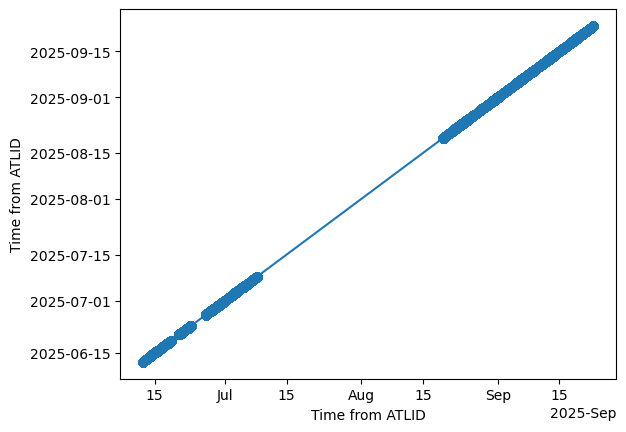

In [4]:
a.time.plot(marker='o')

Tricky coverage: AC_TC is available only half-june / half-july and september


In [5]:
b = xr.open_dataset(f"CPR_CLD_2A_1s{_test}.nc")
b

sh: 1: getfattr: not found


<xarray.Dataset> Size: 23MB
Dimensions:            (time: 581852)
Coordinates:
  * time               (time) datetime64[ns] 5MB 2025-03-11T03:57:14 ... 2025...
Data variables:
    latitude           (time) float64 5MB ...
    longitude          (time) float64 5MB ...
    land_flag          (time) float64 5MB ...
    ice_water_path     (time) float32 2MB ...
    liquid_water_path  (time) float32 2MB ...

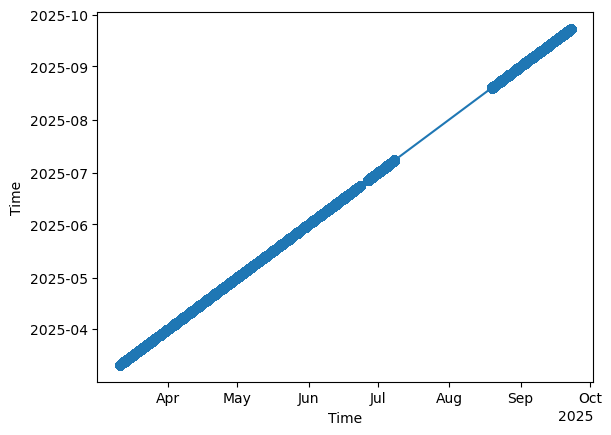

In [6]:
b.time.plot(marker='o')

Coverage: from April to July, then September

In [7]:
challenge = a.merge(b[['land_flag', 'ice_water_path', 'liquid_water_path']], join='outer', compat='override')

In [8]:
c = xr.open_dataset('/home/jovyan/shared-buckets/e87a5ac1-705f-410b-8253-2b53c6d8eaab/data/aot_resampled_wp.nc')
c

<xarray.Dataset> Size: 608kB
Dimensions:                          (time: 50652)
Coordinates:
  * time                             (time) datetime64[ns] 405kB 2025-03-12T0...
Data variables:
    aerosol_optical_thickness_355nm  (time) float32 203kB ...

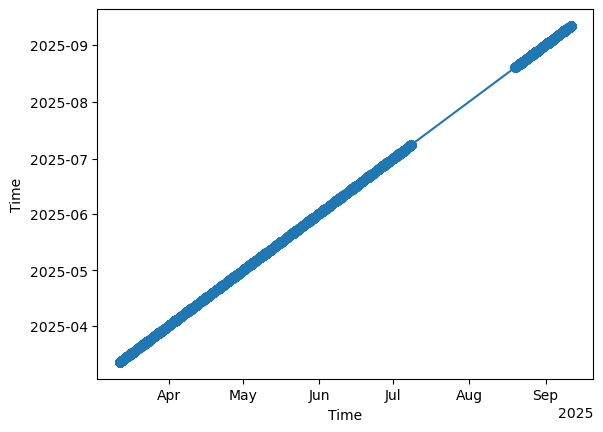

In [9]:
c.time.plot(marker='o')

In [10]:
challenge = challenge.merge(c, join='outer', compat='override')
challenge

<xarray.Dataset> Size: 68MB
Dimensions:                          (time: 632260)
Coordinates:
  * time                             (time) datetime64[ns] 5MB 2025-03-11T03:...
Data variables: (12/14)
    latitude                         (time) float64 5MB nan nan ... 23.34 23.38
    longitude                        (time) float64 5MB nan nan ... 109.0 109.0
    stc_2500                         (time) float64 5MB nan nan ... -1.0 -1.0
    stc_5000                         (time) float64 5MB nan nan ... -1.0 -1.0
    stc_7500                         (time) float64 5MB nan nan ... -1.0 -1.0
    stc_10000                        (time) float64 5MB nan nan ... -1.0 -1.0
    ...                               ...
    stc_17500                        (time) float64 5MB nan nan ... -1.0 -1.0
    stc_20000                        (time) float64 5MB nan nan ... -1.0 -1.0
    land_flag                        (time) float64 5MB 0.0 0.0 0.0 ... nan nan
    ice_water_path                   (time) float32 3MB nan nan nan ... nan nan
    liquid_water_path                (time) float32 3MB nan nan nan ... nan nan
    aerosol_optical_thickness_355nm  (time) float32 3MB nan nan nan ... nan nan

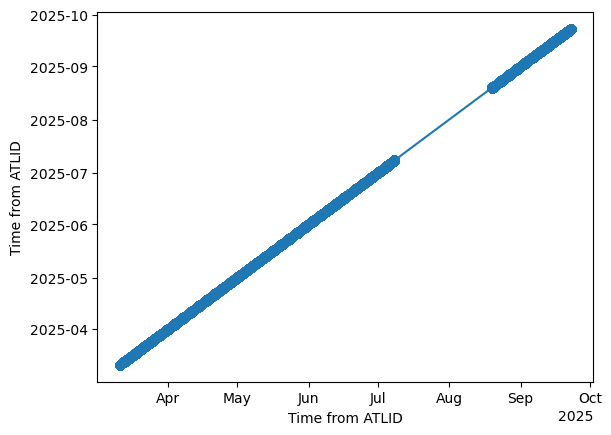

In [11]:
challenge.time.plot(marker='o')

## Let's put nans to zero when sensors are working and sky is clear

In [12]:
numerical_variables = [
    'latitude',
    'longitude',
    'land_flag',
    'ice_water_path', 
    'liquid_water_path', 
    'aerosol_optical_thickness_355nm'
]

In [13]:
challenge[numerical_variables[2:]] = challenge[numerical_variables[2:]].fillna(0).clip(min=0, max=1e2)


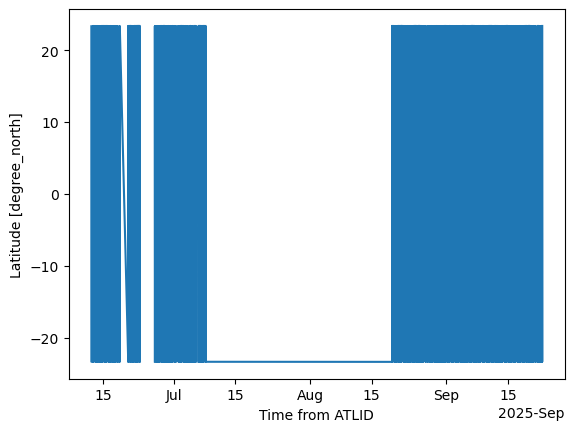

In [14]:
challenge['latitude'].plot()

Now the resampling can be done with how='any'

## Now resample again to 1min
to coarser times to get both aerosols and clouds in the same pixel

Numerical variables with mean:

In [15]:
challenge_1min_numerical = challenge[numerical_variables].resample(time='1min').mean().dropna(dim='time', how='any')
challenge_1min_numerical

<xarray.Dataset> Size: 176kB
Dimensions:                          (time: 3989)
Coordinates:
  * time                             (time) datetime64[ns] 32kB 2025-06-12T06...
Data variables:
    latitude                         (time) float64 32kB 22.89 20.47 ... 23.14
    longitude                        (time) float64 32kB 108.7 108.2 ... 109.0
    land_flag                        (time) float64 32kB 0.2667 0.2143 ... 0.0
    ice_water_path                   (time) float32 16kB 0.1019 0.2666 ... 0.0
    liquid_water_path                (time) float32 16kB 0.1735 0.2327 ... 0.0
    aerosol_optical_thickness_355nm  (time) float32 16kB 0.0 1.139 ... 0.0 0.0

In [16]:
10554/12/5/30 # how many months?

5.863333333333333

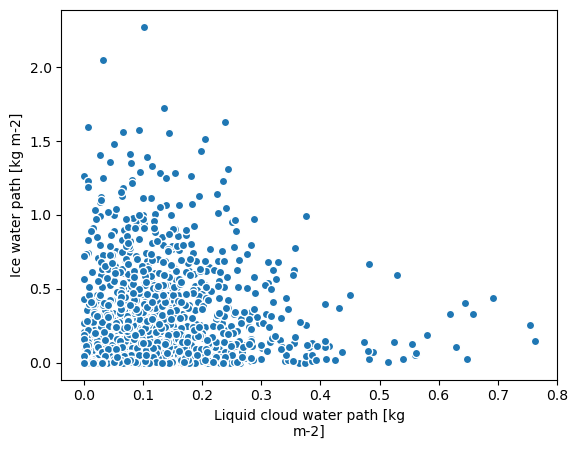

In [17]:
challenge_1min_numerical.plot.scatter(x='liquid_water_path', y='ice_water_path')

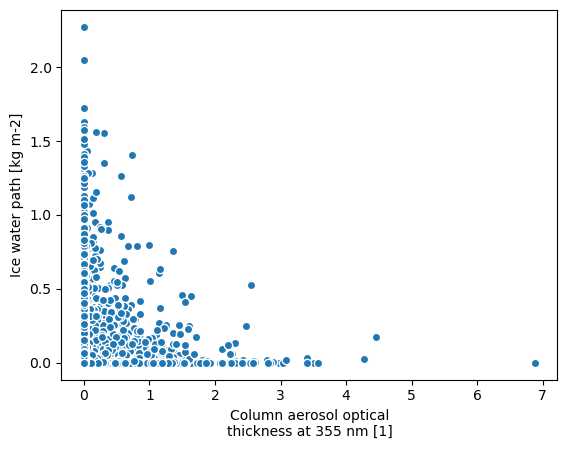

In [18]:
challenge_1min_numerical.plot.scatter(x='aerosol_optical_thickness_355nm', y='ice_water_path')
# plt.xscale('log')

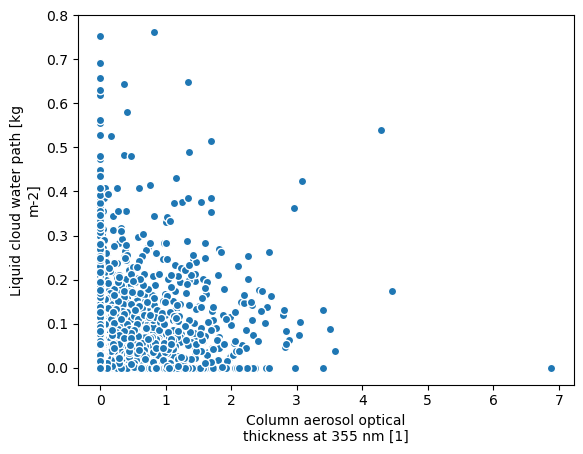

In [19]:
challenge_1min_numerical.plot.scatter(x='aerosol_optical_thickness_355nm', y='liquid_water_path')


## Save the k-means ready dataset

In [20]:
challenge_1min_numerical.to_netcdf('challenge_1min_numerical.nc')

## Resample also the label variables

In [21]:
def mode_func(arr, axis):
    # scipy returns both mode and count, we only want the mode
    return stats.mode(arr, axis=axis, keepdims=False).mode   # , nan_policy="omit"

challenge_1min_labels = (
    challenge
    .drop_vars(numerical_variables)
    .resample(time="1min")
    .reduce(mode_func)
    .dropna(dim="time", how="any")
)

challenge_1min_labels

<xarray.Dataset> Size: 287kB
Dimensions:    (time: 3989)
Coordinates:
  * time       (time) datetime64[ns] 32kB 2025-06-12T06:53:00 ... 2025-09-22T...
Data variables:
    stc_2500   (time) float64 32kB -1.0 11.0 11.0 11.0 ... 7.0 27.0 29.0 -1.0
    stc_5000   (time) float64 32kB -1.0 11.0 5.0 11.0 7.0 ... 7.0 1.0 1.0 1.0
    stc_7500   (time) float64 32kB -1.0 13.0 7.0 13.0 7.0 ... 7.0 1.0 1.0 1.0
    stc_10000  (time) float64 32kB -1.0 7.0 13.0 13.0 13.0 ... 13.0 1.0 1.0 1.0
    stc_12500  (time) float64 32kB -1.0 1.0 13.0 14.0 21.0 ... 21.0 1.0 1.0 1.0
    stc_15000  (time) float64 32kB -1.0 1.0 21.0 21.0 ... 21.0 21.0 21.0 1.0
    stc_17500  (time) float64 32kB -1.0 1.0 21.0 21.0 1.0 ... 1.0 1.0 1.0 1.0
    stc_20000  (time) float64 32kB -1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

In [22]:
challenge_1min_complete = challenge_1min_numerical.merge(challenge_1min_labels, join='outer', compat='override')
challenge_1min_complete

<xarray.Dataset> Size: 431kB
Dimensions:                          (time: 3989)
Coordinates:
  * time                             (time) datetime64[ns] 32kB 2025-06-12T06...
Data variables: (12/14)
    latitude                         (time) float64 32kB 22.89 20.47 ... 23.14
    longitude                        (time) float64 32kB 108.7 108.2 ... 109.0
    land_flag                        (time) float64 32kB 0.2667 0.2143 ... 0.0
    ice_water_path                   (time) float32 16kB 0.1019 0.2666 ... 0.0
    liquid_water_path                (time) float32 16kB 0.1735 0.2327 ... 0.0
    aerosol_optical_thickness_355nm  (time) float32 16kB 0.0 1.139 ... 0.0 0.0
    ...                               ...
    stc_7500                         (time) float64 32kB -1.0 13.0 ... 1.0 1.0
    stc_10000                        (time) float64 32kB -1.0 7.0 ... 1.0 1.0
    stc_12500                        (time) float64 32kB -1.0 1.0 ... 1.0 1.0
    stc_15000                        (time) float64 32kB -1.0 1.0 ... 21.0 1.0
    stc_17500                        (time) float64 32kB -1.0 1.0 ... 1.0 1.0
    stc_20000                        (time) float64 32kB -1.0 1.0 ... 1.0 1.0

## Save the k-means ready dataset with TC labels and layers

In [23]:
challenge_1min_complete.to_netcdf('challenge_1min_complete.nc')


In [24]:
%cp "challenge_1min_complete.nc" "/home/jovyan/my-private-bucket/."